In [282]:
#Import Libraries
import pandas as pd
from pathlib import Path
import pickle

In [283]:
#Import CSV with all data
data_path = Path("historical_data.csv")
historical_data = pd.read_csv(data_path)
historical_data.rename( columns = {"Unnamed: 0":"date"}, inplace = True)
historical_data.head()

,Date,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU,10 YR
0,2008-01-02,32.13,28.34,79.75,28.41,34.94,38.37,41.33,26.10,41.98,3.91
1,2008-01-03,31.78,28.22,80.21,28.20,35.18,38.58,41.80,26.08,42.08,3.91
2,2008-01-04,30.78,28.04,78.01,27.39,34.83,37.60,40.74,25.07,42.30,3.88
3,2008-01-07,30.93,28.55,77.04,27.55,35.57,37.34,40.25,24.97,43.25,3.86
4,2008-01-08,30.32,28.38,76.08,26.54,35.81,36.39,39.60,24.21,43.33,3.86


In [284]:
# Define a function that returns the indexes where the 10 yr treasury momentum crossed a certain threshold
def spike_selector(df):
    signal1 = 0
    daycount1 = 0
    indexes = []
    df["mmt10"] = (df["10 YR"] - df["10 YR"].shift(10))
    df["roll_10"] = df["mmt10"].rolling(20).mean()
    no_idx = df.reset_index()
    for index, row in zip(no_idx.index, no_idx["roll_10"]):
        if signal1 == 1:
            daycount1 += 1
            if daycount1 > 90:
                signal1 = 0
                daycount1 = 0
        if row >= 0.187 and signal1 == 0:
            #print (signal1, daycount1)
            indexes.append(index)
            signal1 = 1
    df.drop(columns = ["mmt10", "roll_10"], inplace = True)
    return indexes

In [285]:
#Create empty dictionary to store new dataframes.  Then slice 90 days following each treaury yeild increase selected by the above function
yield_spikes_dict = {}
for index in spike_selector(historical_data):
    yield_spikes_dict[index] = pd.DataFrame
for index in spike_selector(historical_data):
    start = index
    end = start + 90
    yield_spikes_dict[index] = historical_data.iloc[start: end]

print(yield_spikes_dict.keys())

dict_keys([269, 360, 498, 736, 1357, 2221, 3292])


In [286]:
print(spike_selector(historical_data))


[269, 360, 498, 736, 1357, 2221, 3292]


In [287]:
#For loop to update keys - DOES NOT WORK
count = 1
final_dict={}
spike_list=[]
for key, value in yield_spikes_dict.items():
    new_df = yield_spikes_dict[key]
    new_df.reset_index(inplace=True)
    new_df.drop(columns=['Date','index'], axis=1, inplace=True)
    if new_df["10 YR"].count()>=85:
        final_dict[str("spike_")+str(count)]=new_df
        count +=1
    
print(final_dict.keys())

dict_keys(['spike_1', 'spike_2', 'spike_3', 'spike_4', 'spike_5', 'spike_6'])


/Users/daviddivito/opt/anaconda3/envs/dev/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [288]:
#Updating keys manually
# yield_spikes_dict["spike_1"] = yield_spikes_dict.pop(269)
# yield_spikes_dict["spike_2"] = yield_spikes_dict.pop(360)
# yield_spikes_dict["spike_3"] = yield_spikes_dict.pop(498)
# yield_spikes_dict["spike_4"] = yield_spikes_dict.pop(736)
# yield_spikes_dict["spike_5"] = yield_spikes_dict.pop(1357)
# yield_spikes_dict["spike_6"] = yield_spikes_dict.pop(2221)
# yield_spikes_dict["spike_7"] = yield_spikes_dict.pop(3292)

In [289]:
spikes_df= pd.concat(final_dict.values(), axis = 1, keys = final_dict.keys())
spikes_df.to_pickle('spikes_df.pickle')

In [294]:
spikes_df.head()

spikes_pct_change= spikes_df.pct_change()
spikes_pct_change.to_pickle('spikes_pct_change.pickle')
    
grouped_df=spikes_pct_change.groupby(level = 1, axis = 1).mean()
grouped_df.head()
grouped_df.to_pickle('grouped_df.pickle')


spikes_pct_change.head()

spike_1                                                              \
        XLY       XLP       XLE       XLF       XLV       XLI       XLB   
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1 -0.026754 -0.031537 -0.013673 -0.022129 -0.012439 -0.021354 -0.039234   
2 -0.008817 -0.006784 -0.015782 -0.003233  0.009542 -0.022845 -0.013770   
3  0.028781  0.021403  0.017768 -0.023784  0.023819  0.018383  0.018296   
4 -0.022889 -0.026750  0.006813 -0.008859 -0.006278 -0.005330  0.016548   

                                 ...   spike_6                                \
        XLK       XLU     10 YR  ...       XLY       XLP       XLE       XLF   
0       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
1 -0.025132 -0.022965  0.000000  ...  0.012243  0.004916 -0.000618  0.000450   
2  0.014925  0.004839 -0.038328  ...  0.000968 -0.005675  0.004879  0.005843   
3  0.017380  0.007912  0.047101  ...  0.002537  0.007774 -0.005334  0.002234   
4 -0.000657  0.007850  0.020761  ... -0.007714  0.002246 -0.014298 -0.013375   

                                                               
        XLV       XLI       XLB       XLK       XLU     10 YR  
0       NaN       NaN       NaN       NaN       NaN       NaN  
1 -0.013732  0.004529  0.006136  0.002717  0.003420 -0.008584  
2  0.003626  0.007348  0.004879 -0.003960 -0.009480  0.021645  
3  0.003757  0.005471  0.003035  0.004185  0.014195  0.000000  
4 -0.007774 -0.006925 -0.004236  0.000834  0.019722 -0.016949  

[5 rows x 60 columns]

<AxesSubplot:>

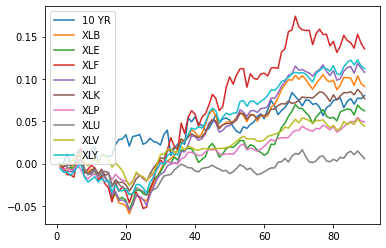

In [295]:
returns_df = (1+grouped_df).cumprod() -1
returns_df.to_pickle('returns_df.pickle')

returns_df.plot()

In [376]:
sector_list = list(spikes_pct_change.columns.levels[1]) 
sector_dict={}
for sector in sector_list:
    sector_dict[str(sector)]=spikes_pct_change.xs(sector, level=1, axis=1)
sector_df= pd.concat(sector_dict.values(), axis = 1, keys = sector_dict.keys())
sector_df.to_pickle('sector_df.pickle')
sector_df.head()

XLY                                                         XLP  \
    spike_1   spike_2   spike_3   spike_4   spike_5   spike_6   spike_1   
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1 -0.026754 -0.009136 -0.003972 -0.005057 -0.002816  0.012243 -0.031537   
2 -0.008817  0.001257 -0.009305 -0.000535 -0.009531  0.000968 -0.006784   
3  0.028781 -0.021766  0.006374 -0.003212 -0.011048  0.002537  0.021403   
4 -0.022889 -0.022251  0.004000  0.007519  0.018018 -0.007714 -0.026750   

                                 ...       XLU                                \
    spike_2   spike_3   spike_4  ...   spike_3   spike_4   spike_5   spike_6   
0       NaN       NaN       NaN  ...       NaN       NaN       NaN       NaN   
1  0.000857 -0.001120  0.000000  ...  0.000318  0.005141 -0.001972  0.003420   
2  0.005563 -0.011589  0.005493  ... -0.014921  0.002238 -0.006061 -0.009480   
3 -0.021277  0.010590  0.001366  ...  0.002256 -0.008612 -0.010870  0.014195   
4 -0.011304 -0.001123  0.007842  ... -0.011576  0.008687  0.017154  0.019722   

      10 YR                                                    
    spike_1   spike_2   spike_3   spike_4   spike_5   spike_6  
0       NaN       NaN       NaN       NaN       NaN       NaN  
1  0.000000 -0.025126 -0.005236 -0.009036  0.023041 -0.008584  
2 -0.038328 -0.018041  0.013158  0.060790 -0.009009  0.021645  
3  0.047101 -0.013123  0.000000  0.011461  0.022727  0.000000  
4  0.020761 -0.023936 -0.020779 -0.016997 -0.026667 -0.016949  

[5 rows x 60 columns]

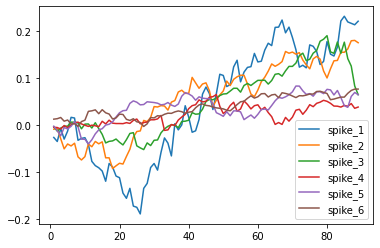

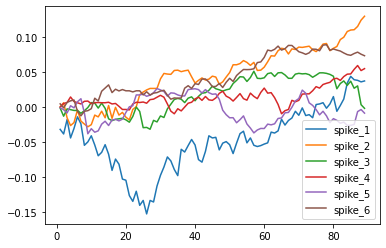

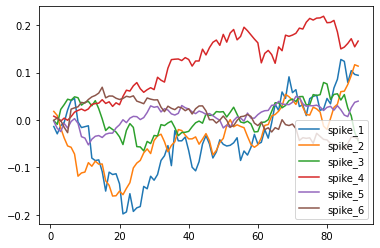

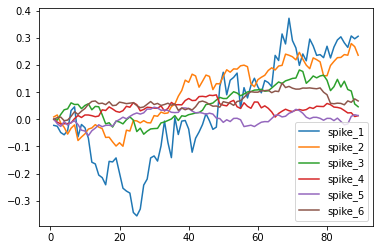

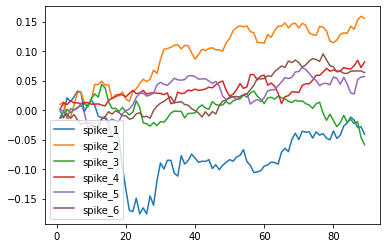

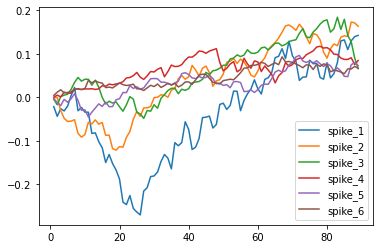

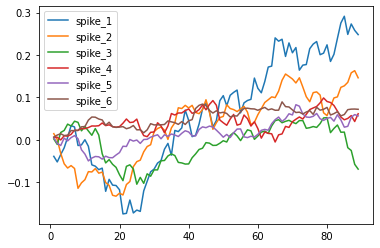

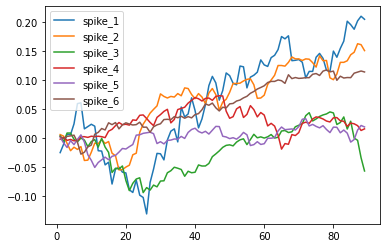

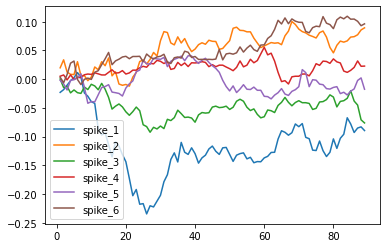

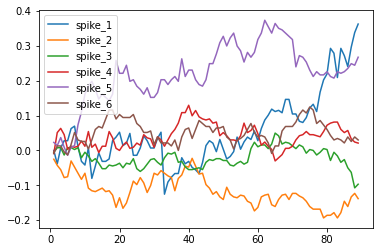

In [377]:
sector_list2 = list(sector_df.columns.levels[0])
for sector in sector_list2:
    individual_returns_df = (1+sector_df[sector]).cumprod() -1
    individual_returns_df.plot()
